# Guided Project: Predicting Employee Productivity Using Tree Models

## Table of contents

## Introduction
We'll be looking at the garment industry and some stats about employees



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv('garments_worker_productivity.csv')

## Data Exploration

The dataset is from a garment manufacturer about worker productivity and is available
(https://archive.ics.uci.edu/dataset/597/productivity+prediction+of+garment+employees). The manufacturer is based in Bangladesh, and workers
were paid in Bangladeshi Taka (**৳** / **BDT**). The data represents about 2.5 months of work from the start of 2015

### Data Schema



| **Variable Name**       | **Role**       | **Type**          | **Description**                                                                            | **Units** | **Missing Values** |
|-------------------------|----------------|--------------------|--------------------------------------------------------------------------------------------|-----------|---------------------|
| `date`                  | Feature        | Date              | Date in MM-DD-YYYY                                                                         |           | no                  |
| `quarter`               | Feature        | Categorical       | A portion of the month. A month was divided into four quarters                             |           | no                  |
| `department`            | Feature        | Categorical       | Associated department with the instance                                                    |           | no                  |
| `day`                   | Feature        | Categorical       | Day of the Week                                                                            |           | no                  |
| `team_no`               | Feature        | Integer           | Associated team number with the instance                                                   |           | no                  |
| `no_of_workers`         | Feature        | Integer           | Number of workers in each team                                                             |           | no                  |
| `no_of_style_change`    | Feature        | Integer           | Number of changes in the style of a particular product                                     |           | no                  |
| `targeted_productivity` | Feature        | Continuous        | Targeted productivity set by the Authority for each team for each day.                     |           | no                  |
| `smv`                   | Feature        | Continuous        | Standard Minute Value, it is the allocated time for a task                                 |           | no                  |
| `wip`                   | Feature        | Integer           | Work in progress. Includes the number of unfinished items for products                     |           | yes                 |
| `over_time`             | Feature        | Integer           | Represents the amount of overtime by each team in minutes                                  |           | no                  |
| `incentive`             | Feature        | Integer           | Represents the amount of financial incentive (in BDT) that enables or motivates a behavior | BDT       | no                  |
| `idle_time`             | Feature        | Integer           | The amount of time when the production was <br/>interrupted due to several reasons         |           | no                  |
| `idle_men`               | Feature        | Integer           | The number of workers who were idle due to production interruption                         |           | no                  |
| `actual_productivity`     | Target         | Continuous        | The actual % of productivity that was delivered by the workers. It ranges from 0-1.        |           | no                  |

In [3]:
df.head()
df.shape

(1197, 15)

In [4]:

df['productive'] = (df['actual_productivity'] > df['targeted_productivity']).astype(int)


~ 1200 rows and 14 features

### Missing values
The schema indicates there is some missing data for the `wip` feature. Let's take a look

In [5]:
df['wip'].describe()

count      691.000000
mean      1190.465991
std       1837.455001
min          7.000000
25%        774.500000
50%       1039.000000
75%       1252.500000
max      23122.000000
Name: wip, dtype: float64

In [6]:
non_numeric_count = df['wip'].apply(pd.to_numeric, errors='coerce').isnull().sum()
print("Number of non-numeric values:", non_numeric_count)

Number of non-numeric values: 506


It looks about a half of the data set is missing that for this feature. That's too much to exclude

In [7]:
zero_count = (df['wip'] == 0).sum()
print("Number of 0 values in 'wip':", zero_count)

Number of 0 values in 'wip': 0


It's reasonable to assume since there's no zero values, and Works In Progress (WIP) is an integer representing the
amount of garments still to be made, that a lack of entry could be considered to be zero, so we'll impute that

In [8]:
missing_count_by_dept = df.groupby('department')['wip'].apply(lambda x: x.isnull().sum())
print("Number of missing values in 'wip' by department:\n", missing_count_by_dept)

Number of missing values in 'wip' by department:
 department
finishing     249
finishing     257
sweing          0
Name: wip, dtype: int64


The sewing department is the only one with Works In Progress being tracked. The finishing department is either not
tracking works in progress or always completes all works. There's also two strings representing the finishing
department that will need to be merged, caused by extra whitespace

### Data shapes

In [9]:
unique_counts = {col: df[col].nunique() for col in df.columns}
unique_counts

{'date': 59,
 'quarter': 5,
 'department': 3,
 'day': 6,
 'team': 12,
 'targeted_productivity': 9,
 'smv': 70,
 'wip': 548,
 'over_time': 143,
 'incentive': 48,
 'idle_time': 12,
 'idle_men': 10,
 'no_of_style_change': 3,
 'no_of_workers': 61,
 'actual_productivity': 879,
 'productive': 2}

There's 2 `department`s, 12 `team`s, 61 team sizes, interestingly, the `targeted_productivity` and the
`actual_productivity` have about two orders of magnitude difference. Indicating that for a given `target_productivity`
there could be 10 to 100 values for it's `actual_productivity`

In [10]:
{col: df[col].unique() for col in ['team', 'idle_time', 'idle_men', 'no_of_style_change', 'targeted_productivity']}

{'team': array([ 8,  1, 11, 12,  6,  7,  2,  3,  9, 10,  5,  4]),
 'idle_time': array([  0. ,  90. , 150. , 270. , 300. ,   2. ,   5. ,   8. ,   4.5,
          3.5,   4. ,   6.5]),
 'idle_men': array([ 0, 10, 15, 45, 37, 30, 35, 20, 25, 40]),
 'no_of_style_change': array([0, 1, 2]),
 'targeted_productivity': array([0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.35, 0.5 , 0.07, 0.4 ])}

Let's add a label feature to mark a shift as productive if it's actual productivity equaled or exceeded it's target

In [11]:
df['productive'] = (df['actual_productivity'] >= df['targeted_productivity']).astype(int)
df.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,productive
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,1
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500,1
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,1


In [12]:
df['idle_time'].value_counts()

idle_time
0.0      1179
3.5         3
2.0         2
8.0         2
4.0         2
4.5         2
5.0         2
90.0        1
270.0       1
150.0       1
300.0       1
6.5         1
Name: count, dtype: int64

In [13]:

df['productive'] = (df['actual_productivity'] > df['targeted_productivity']).astype(int)
df.head()


,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,productive
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,1
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500,1
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,1


Only 18 `idle_time` values that are non-zero, interesting. Probably indicating this feature is not going to be a
great predictor of productivity given the limited data, but it would be unfair to ignore it

In [14]:
df['idle_men'].value_counts()

idle_men
0     1179
10       3
15       3
30       3
20       3
35       2
37       1
45       1
25       1
40       1
Name: count, dtype: int64

There's 18 non-zero values for `idle_men` as well. Let's take a look at those data entries

In [15]:
df[(df['idle_men'] > 0) & (df['idle_time'] > 0)]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,productive
615,2/4/2015,Quarter1,sweing,Wednesday,5,0.65,30.10,326.0,5820,0,90.0,10,0,58.5,0.650835,1
617,2/4/2015,Quarter1,sweing,Wednesday,4,0.35,30.10,287.0,6060,23,150.0,15,0,55.5,0.350706,1
650,2/7/2015,Quarter1,sweing,Saturday,7,0.70,24.26,658.0,6960,0,270.0,45,0,58.0,0.662270,0
654,2/7/2015,Quarter1,sweing,Saturday,8,0.70,24.26,652.0,6840,0,300.0,37,0,57.0,0.365319,0
775,2/15/2015,Quarter3,sweing,Sunday,8,0.70,30.10,507.0,5880,40,2.0,10,1,59.0,0.700573,1
798,2/16/2015,Quarter3,sweing,Monday,8,0.70,30.10,7.0,7080,27,2.0,10,2,59.0,0.621972,0
818,2/17/2015,Quarter3,sweing,Tuesday,8,0.60,29.40,179.0,0,23,5.0,30,2,58.0,0.600983,1
822,2/17/2015,Quarter3,sweing,Tuesday,10,0.65,18.22,741.0,0,0,8.0,35,1,49.0,0.302117,0
841,2/18/2015,Quarter3,sweing,Wednesday,10,0.70,19.68,1119.0,5640,0,8.0,35,1,47.0,0.303574,0
843,2/18/2015,Quarter3,sweing,Wednesday,8,0.65,29.40,962.0,4560,0,4.5,30,2,57.0,0.251399,0


Looks like it was just the sewing department that had downtime

### Targeted vs Actual productivity

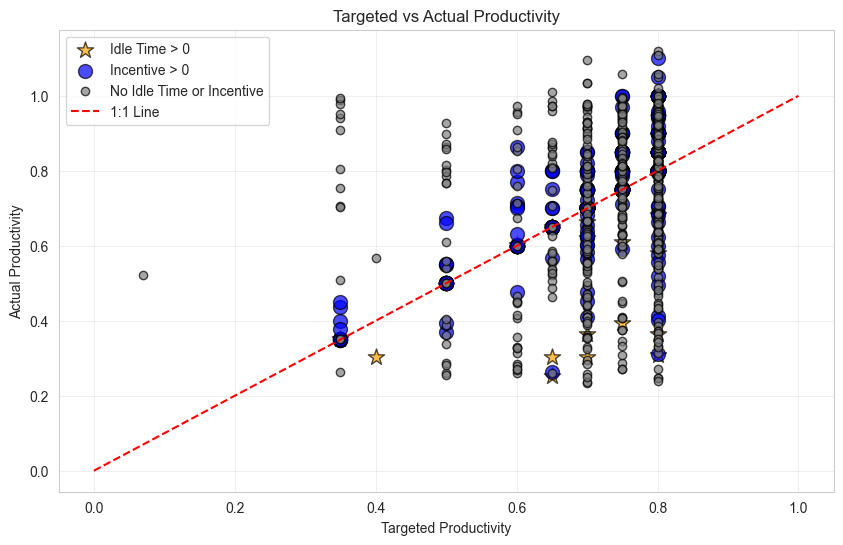

In [16]:
plt.figure(figsize=(10, 6))

# Create scatter plot for points with idle time > 0 (stars)
scatter_idle_time = plt.scatter(
	df[df['idle_time'] > 0]['targeted_productivity'],
	df[df['idle_time'] > 0]['actual_productivity'],
	marker='*', c='orange', label='Idle Time > 0', alpha=0.7, edgecolor='k', s=150
)

# Create scatter plot for points with incentive > 0 (colored differently)
scatter_incentive = plt.scatter(
	df[df['incentive'] > 0]['targeted_productivity'],
	df[df['incentive'] > 0]['actual_productivity'],
	marker='o', c='blue', label='Incentive > 0', alpha=0.7, edgecolor='k', s=100
)

# Create scatter plot for points with neither condition (default appearance)
scatter_default = plt.scatter(
	df[(df['idle_time'] == 0) & (df['incentive'] == 0)]['targeted_productivity'],
	df[(df['idle_time'] == 0) & (df['incentive'] == 0)]['actual_productivity'],
	marker='o', c='gray', label='No Idle Time or Incentive', alpha=0.7, edgecolor='k'
)

# Add a 1:1 line for targeted vs actual productivity
plt.plot([0, 1], [0, 1], 'r--', label='1:1 Line')

plt.title("Targeted vs Actual Productivity")
plt.xlabel("Targeted Productivity")
plt.ylabel("Actual Productivity")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Everything above the red line represents a productive shift

### Data distributions

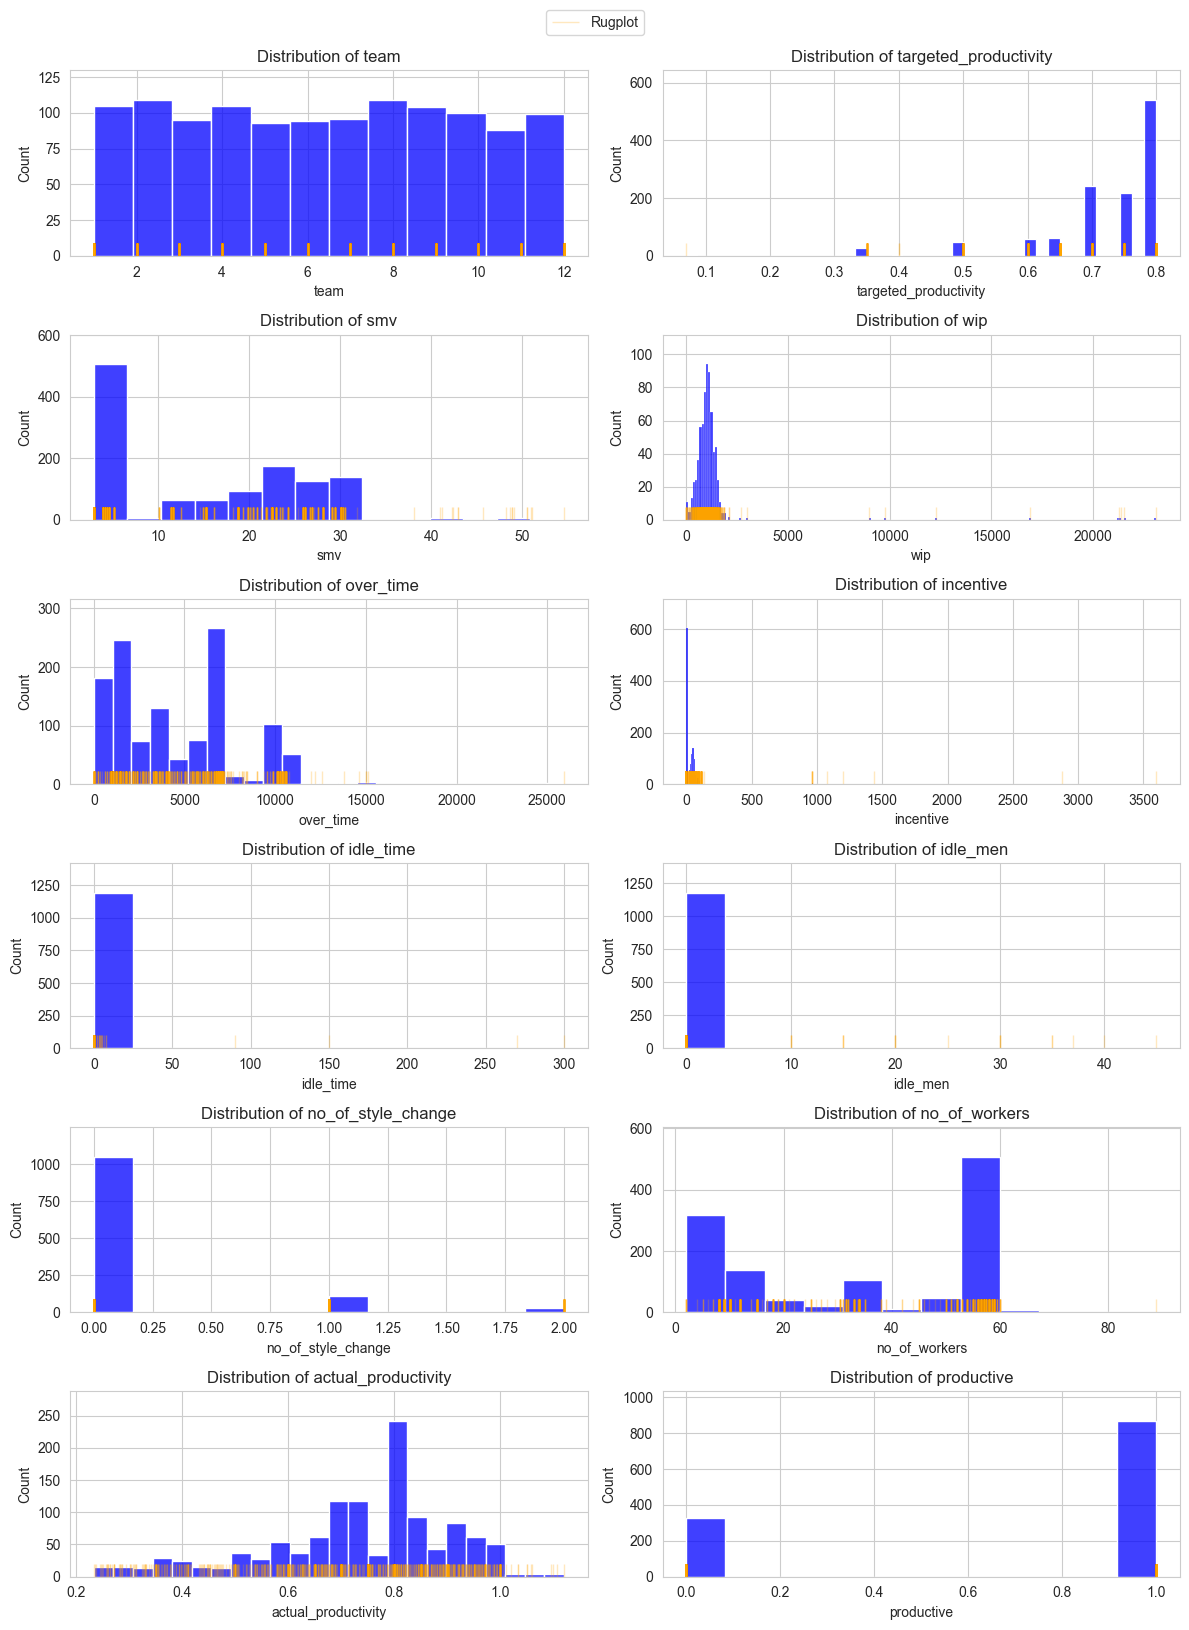

In [17]:
numeric_columns = df.select_dtypes(include=['number']).columns
plt.figure(figsize=(12, 16))  # Adjusted figure size to match two-column layout
for i, col in enumerate(numeric_columns, 1):
	plt.subplot((len(numeric_columns) + 1) // 2, 2, i)  # Two columns layout
	sns.histplot(df[col], kde=False, color='blue', bins='auto')  # Added histogram
	sns.rugplot(df[col], height=0.07, alpha=0.25, color='orange', label='Rugplot')  # Overlayed rugplot
	plt.title(f'Distribution of {col}')
	plt.tight_layout()

# Add a legend to the top of the overall figure
plt.figlegend(['Rugplot'], loc='upper center', ncol=1, bbox_to_anchor=(0.5, 1.02))

plt.show()

There's some interesting data

- for `wip` it seems normally distributed with a few outliers an order of magnitude higher. Possibly erroneous data
entry
- for `incentive` it seems normally distributed, with a few outliers much higher, but also a lot of shifts with no
incentive
-

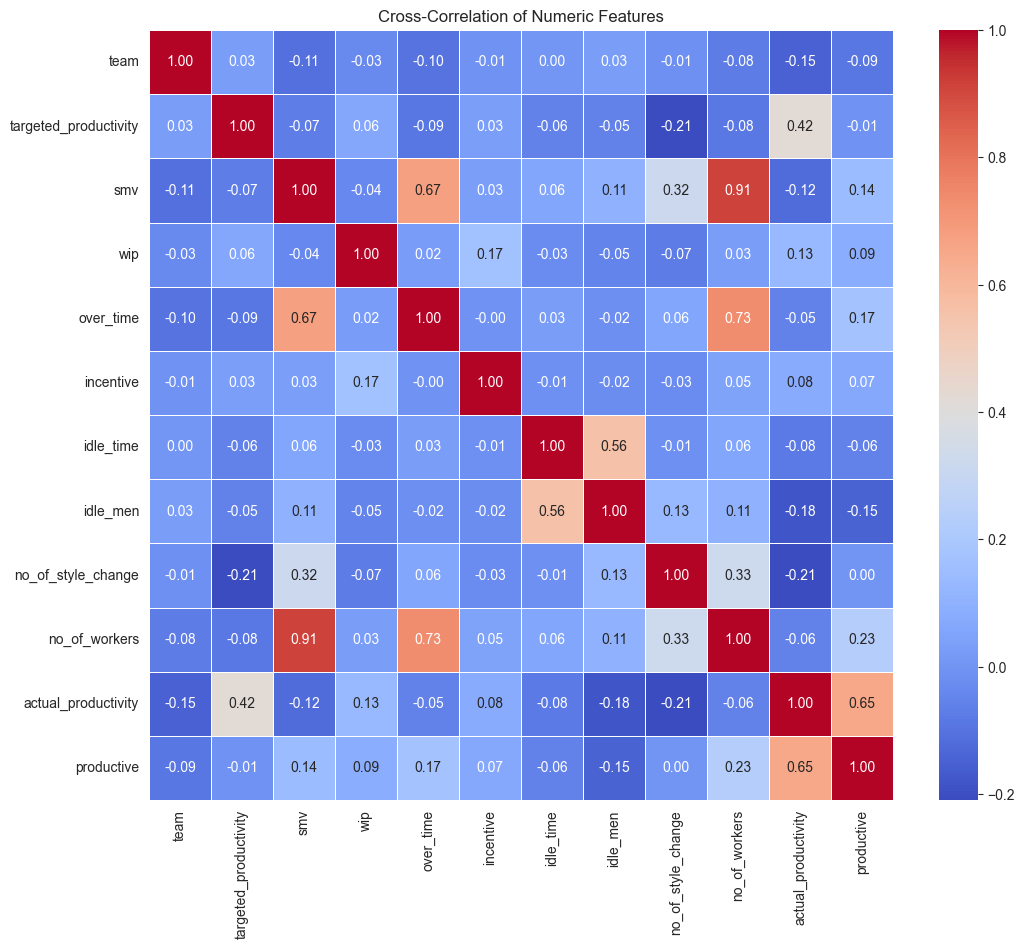

In [18]:
# Select only numeric columns for cross-correlation
numeric_features = df.select_dtypes(include=['number'])

# Calculate the correlation matrix for numeric features
correlation_matrix = numeric_features.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Cross-Correlation of Numeric Features")
plt.show()

The strong correlations for predicting whether a given entry is productive is the number of workers and overtime and
the smv

### Summary

| **Variable Name**       | **Cleaning?**                              | **Transformer** | **Keep Feature?**|
|-------------------------|--------------------------------------------|-----------------|-----------------|
| `date`                  | No                                         | none            | No              |
| `quarter`               | Merge Q5 into Q4                           | One-hot encode  | Yes             |
| `department`            | Fix string import                          | One-hot encode  | Yes             |
| `day`                   | None                                       | One-hot encode  | Yes             |
| `team_no`               | None                                       | One-hot encode  | Yes             |
| `no_of_workers`         | Handle outliers                            | Scale/normalize | Yes             |
| `no_of_style_change`    | None                                       | One-hot encode  | Yes             |
| `targeted_productivity` | Handle outliers, ensure 0-1 range          | None            | Yes             |
| `smv`                   | Handle outliers                            | Scale/normalize | Yes             |
| `wip`                   | Impute missing values as 0                 | Scale/normalize | Yes             |
| `over_time`             | Handle outliers normalise to `no_of_workers` | Scale/normalize | Yes             |
| `incentive`             | Handle outliers                            | Scale/normalize | Yes             |
| `idle_time`             | Handle outliers                            | Scale/normalize | Yes             |
| `idle_men`              | Handle outliers                            | Scale/normalize | Yes             |
| `actual_productivity`   | Ensure 0-1 range, rounding to 2 decimal    | None            | Yes             |


In [19]:
from sklearn.base import BaseEstimator, TransformerMixin


# Custom transformer to handle feature names
class CustomFunctionTransformer(BaseEstimator, TransformerMixin):
	def __init__(self, func=None, feature_names_func=None):
		self.func = func
		self.feature_names_func = feature_names_func
		self.transformer = FunctionTransformer(func)

	def fit(self, X, y=None):
		self.transformer.fit(X, y)
		return self

	def transform(self, X):
		return self.transformer.transform(X)

	def get_feature_names_out(self, input_features=None):
		if self.feature_names_func is not None:
			return self.feature_names_func(input_features)
		if input_features is not None:
			return input_features  # Default: return input feature names unmodified
		raise ValueError("input_features must be provided for feature name transformation")


# Example custom functions for each step
def remove_whitespace_transformer(X):
	if not isinstance(X, pd.DataFrame):
		X = pd.DataFrame(X)
	return X.map(lambda x: x.strip() if isinstance(x, str) else x)


def remove_whitespace_feature_names(input_features):
	return input_features  # No change in feature names for this step


remove_whitespace = CustomFunctionTransformer(
	func=remove_whitespace_transformer,
	feature_names_func=remove_whitespace_feature_names
)

# Updated Data Cleaning Transformer
data_cleaning_transformer = ColumnTransformer(
	transformers=[
			# Clean and encode department column
			('department_pipeline', Pipeline(
				steps=[
						('remove_whitespace', remove_whitespace),
						('onehot_department', OneHotEncoder(sparse_output=False))
				]
			), ['department']),
			# Clean and encode quarter column
			('quarter_pipeline', Pipeline(
				steps=[
						('merge_quarter', CustomFunctionTransformer(
							func=lambda x: x.replace('Quarter5', 'Quarter4'),
							feature_names_func=lambda x: x  # No change in feature names
						)),
						('onehot_quarter', OneHotEncoder(sparse_output=False))
				]
			), ['quarter']),
			('team', OneHotEncoder(sparse_output=False), ['team']),
			# Scale/normalize numeric columns
			('scale_normalize', Pipeline(
				steps=[
						('impute_zeros', CustomFunctionTransformer(
							func=lambda x: x.fillna(0),
							feature_names_func=lambda x: x
						)),
						('round_to_2_decimal', CustomFunctionTransformer(
							func=lambda x: x.round(2),
							feature_names_func=lambda x: x
						)),
				]
			), ['no_of_workers', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time',
			    'idle_men'])
	],
	remainder='drop'
).set_output(transform="pandas")



In [20]:
transformed_data = data_cleaning_transformer.fit_transform(df)
transformed_data.head()

,department_pipeline__department_finishing,department_pipeline__department_sweing,quarter_pipeline__quarter_Quarter1,quarter_pipeline__quarter_Quarter2,quarter_pipeline__quarter_Quarter3,quarter_pipeline__quarter_Quarter4,team__team_1,team__team_2,team__team_3,team__team_4,...,team__team_11,team__team_12,scale_normalize__no_of_workers,scale_normalize__targeted_productivity,scale_normalize__smv,scale_normalize__wip,scale_normalize__over_time,scale_normalize__incentive,scale_normalize__idle_time,scale_normalize__idle_men
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,59.0,0.80,26.16,1108.0,7080,98,0.0,0
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,8.0,0.75,3.94,0.0,960,0,0.0,0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,30.5,0.80,11.41,968.0,3660,50,0.0,0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,30.5,0.80,11.41,968.0,3660,50,0.0,0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,56.0,0.80,25.90,1170.0,1920,50,0.0,0


The pipeline transforms the data as we expect

## Building the Tree
### Splitting the data set

In [39]:
X = df.drop('productive', axis=1)
Y = df['productive']

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

### Tree Classifier Pipeline

In [40]:
tree_pipeline = Pipeline(
	steps=[
			('data_cleaning', data_cleaning_transformer),
			('tree_model', DecisionTreeClassifier(random_state=42, max_depth=4))
	]
)

### Model scoring

C:\Users\User\Dataquest.IO\venv\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.


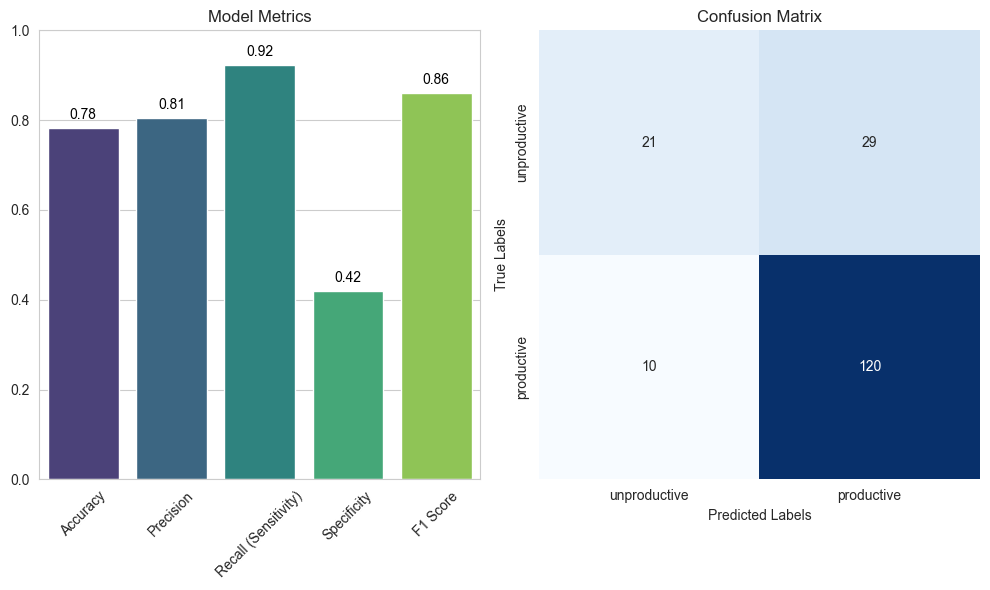

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

def display_model_stats(model, X_train, Y_train, X_val, Y_val):
    # Fit the model
    model.fit(X_train, Y_train)

    # Make predictions
    y_val_pred = model.predict(X_val)

    # Replace numerical labels with categorical ones for better readability
    Y_val = Y_val.map({0: 'unproductive', 1: 'productive'})
    y_val_pred = pd.Series(y_val_pred).map({0: 'unproductive', 1: 'productive'})

    # Calculate metrics
    precision = precision_score(Y_val, y_val_pred, pos_label='productive')
    recall = recall_score(Y_val, y_val_pred, pos_label='productive')
    f1 = f1_score(Y_val, y_val_pred, pos_label='productive')
    accuracy = accuracy_score(Y_val, y_val_pred)

    # Sensitivity is the same as recall (true positive rate)
    sensitivity = recall

    # Specificity calculation
    conf_matrix = confusion_matrix(Y_val, y_val_pred, labels=['unproductive', 'productive'])
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Display confusion matrix
    conf_matrix = confusion_matrix(Y_val, y_val_pred, labels=['unproductive', 'productive'])

    # Plotting the metrics
    plt.figure(figsize=(10, 6))

    # Plot bar chart for metrics with numeric values displayed
    plt.subplot(1, 2, 1)
    metrics = ['Accuracy', 'Precision', 'Recall (Sensitivity)', 'Specificity', 'F1 Score']
    values = [accuracy, precision, sensitivity, specificity, f1]
    sns.barplot(x=metrics, y=values, hue=metrics, dodge=False, palette="viridis")
    plt.ylim(0, 1)
    plt.title("Model Metrics")
    plt.xticks(rotation=45)
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f"{v:.2f}", color="black", ha="center")  # Add text to display metric values

    # Plot the confusion matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['unproductive', 'productive'], yticklabels=['unproductive', 'productive'])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")

    plt.tight_layout()
    plt.show()

# Example usage:
display_model_stats(tree_pipeline, X_train, Y_train, X_val, Y_val)

### Iniitial classifier results
The classifier is very good at determining productive shifts (sensitivity), but misses about half of the unproductive
 (specificity)
ones. Now that we can visualise the accuracy of the model, let's look at the tree itself


### Tree visualisation

In [24]:
tree_pipeline.named_steps['tree_model'].classes_

array([0, 1])

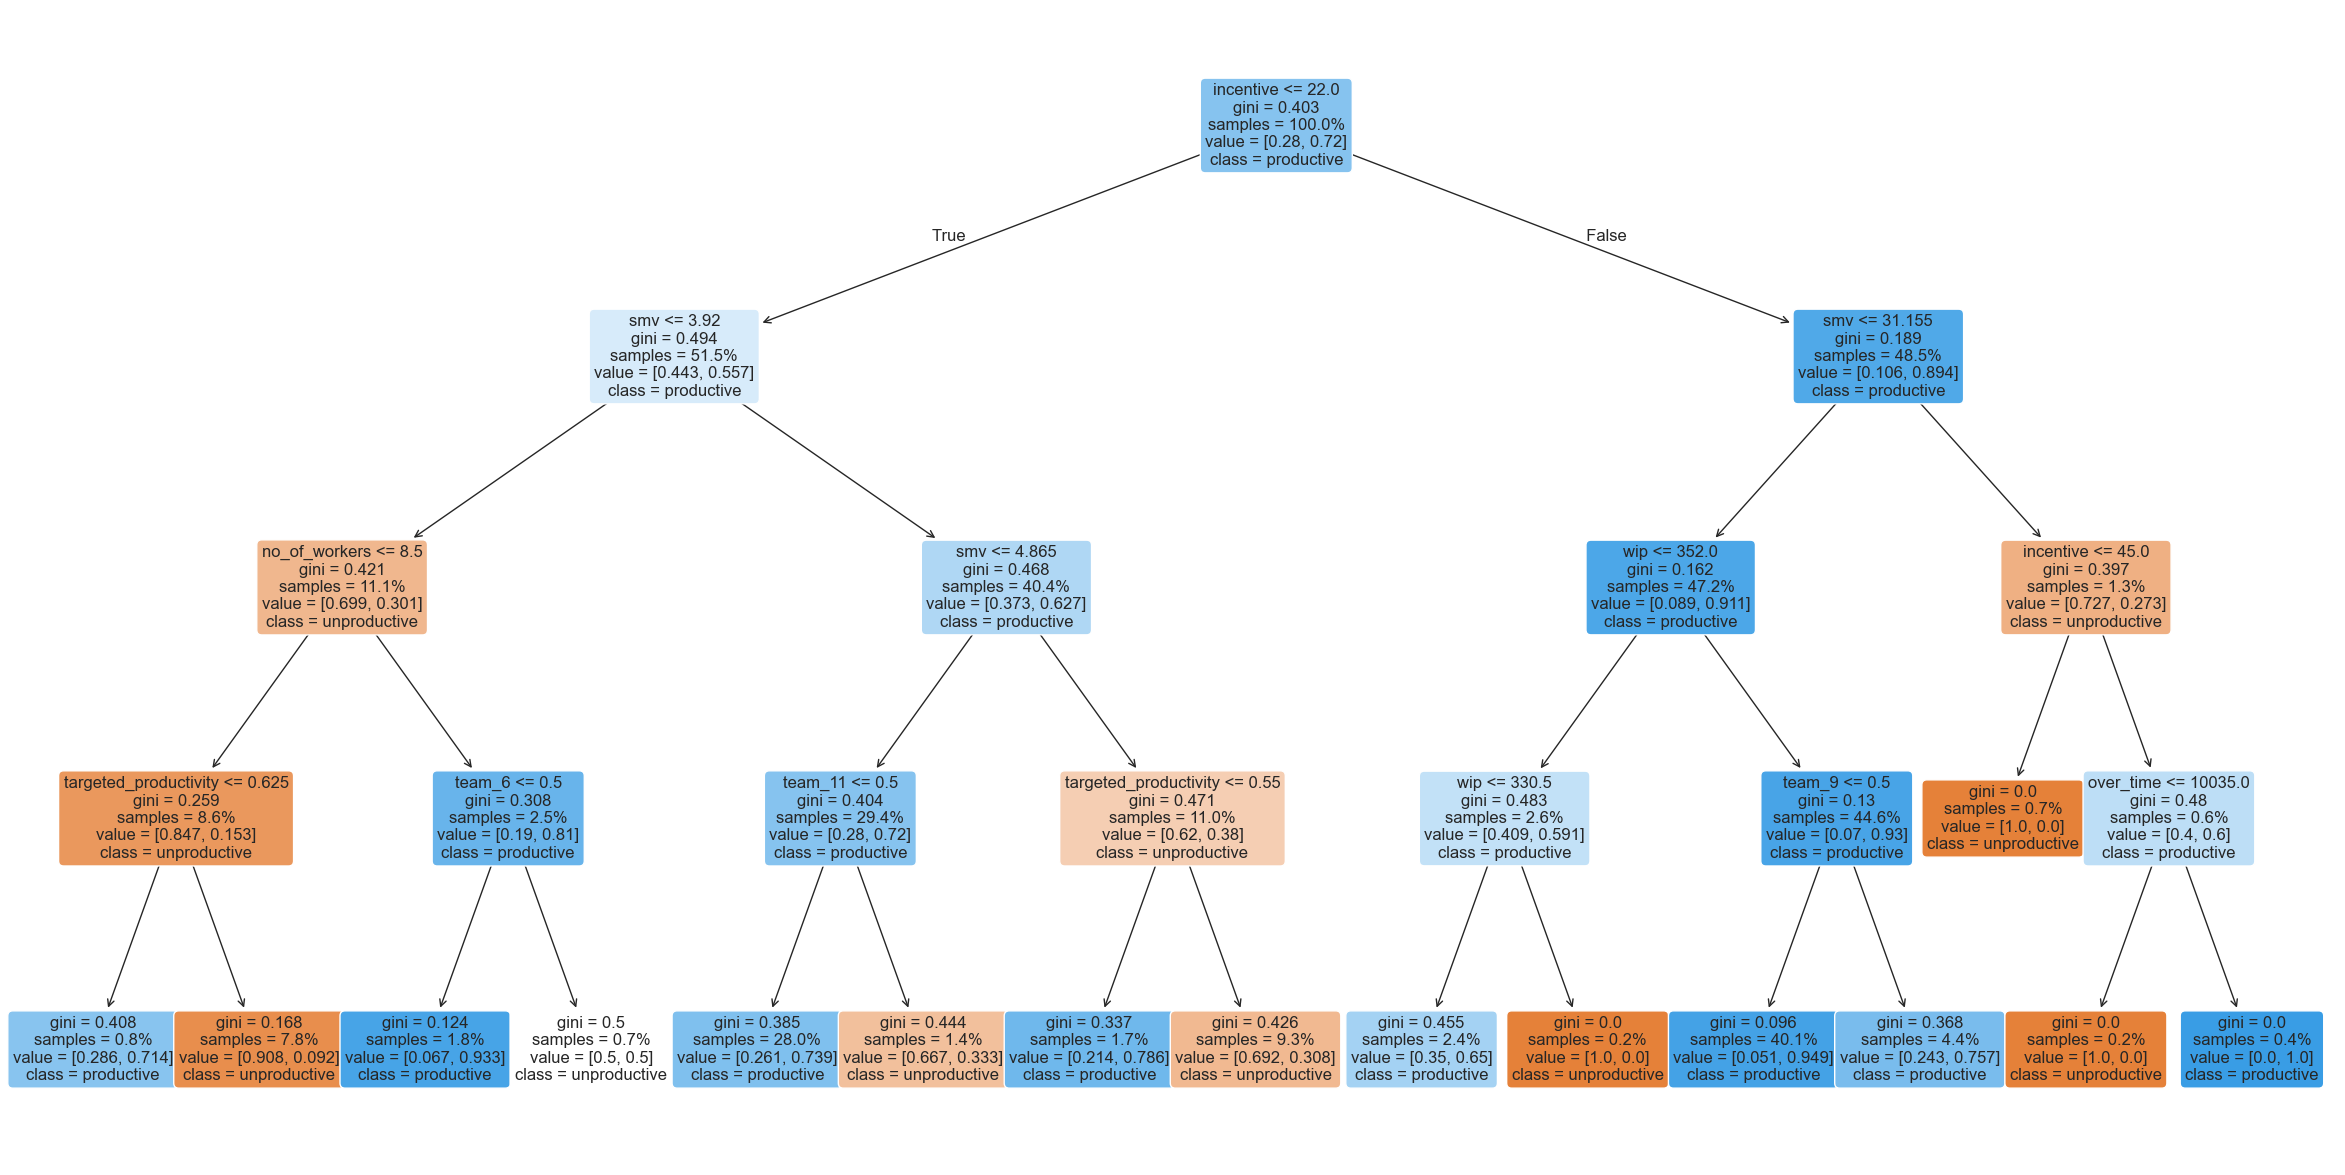

In [25]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Modify the feature names to remove pipeline prefixes or shorten them
clean_feature_names = [name.split('__')[-1] for name in data_cleaning_transformer.get_feature_names_out()]

plt.figure(figsize=(30, 15))
plot_tree(
	tree_pipeline.named_steps['tree_model'],
	feature_names=clean_feature_names,
	class_names=['unproductive', 'productive'],
	filled=True,
	rounded=True,
	proportion=True,
	fontsize=12
	)
plt.show()

### Initial tree results
The decision tree indicates that `incentive` and `smv` are the two strongest predictors for whether the workers will
be productive. The works in progress cut off is interesting. THere's also some interesting team based selection at
the 3rd layer.


### Improving tree visualisation
Let's see if we can get some different views of further down the tree when the depth is higher. There's better
modules for viewing a tree. We'll use dtreeviz

In [26]:
import dtreeviz
from dtreeviz.utils import extract_params_from_pipeline

tree_classifier, X1_train, features_model = extract_params_from_pipeline(
	tree_pipeline, X_train,
	feature_names=X_train.columns
	)

C:\Users\User\Dataquest.IO\venv\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.


In [27]:
# Modify features_model to strip out the pipeline step names
features_model = [name.split('__')[-1] for name in features_model]

C:\Users\User\Dataquest.IO\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable da

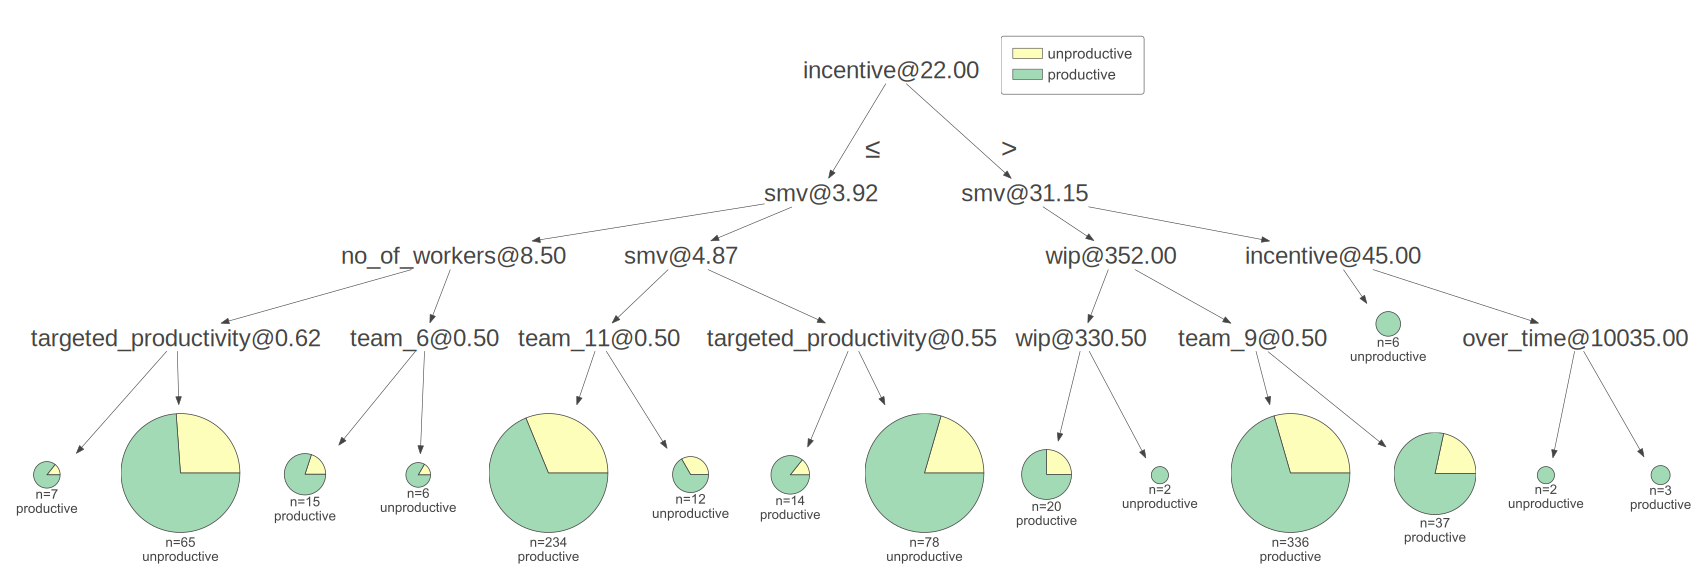

In [42]:
viz_model = dtreeviz.model(
	tree_classifier,
	X_train=X1_train,
	y_train=Y_train,
	feature_names=features_model,
	class_names=['unproductive', 'productive']
	)

custom_colors = ["#1f77b4"]  # Example for a single dataset
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=custom_colors)  # Set single dataset color

# Render the visualization (ensure this part uses correct inputs)
# The view() method internally uses matplotlib, so we match inputs
viz_model.view(scale=2, fancy=False)


This type of visualisation it's a bit easier to see the data split. Team 11 misses productivity targets more when
working on garments between 3.92 and 4.87 minutes, compared with the rest at ~75% productive shifts. Now that we have
a good way to visualise the tree, let's try to fit a better model


## Improving the model
### Random Forest
If we use a random forest method and have it optimise for the F1 score and specificity we'll hopefully get a better
model

In [55]:
from sklearn.ensemble import RandomForestClassifier

random_forest_pipeline = Pipeline(steps =[
        ('data_cleaning', data_cleaning_transformer),
		('random_forest', RandomForestClassifier(random_state=42, n_estimators=1000, oob_score=))],
	)


C:\Users\User\Dataquest.IO\venv\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.


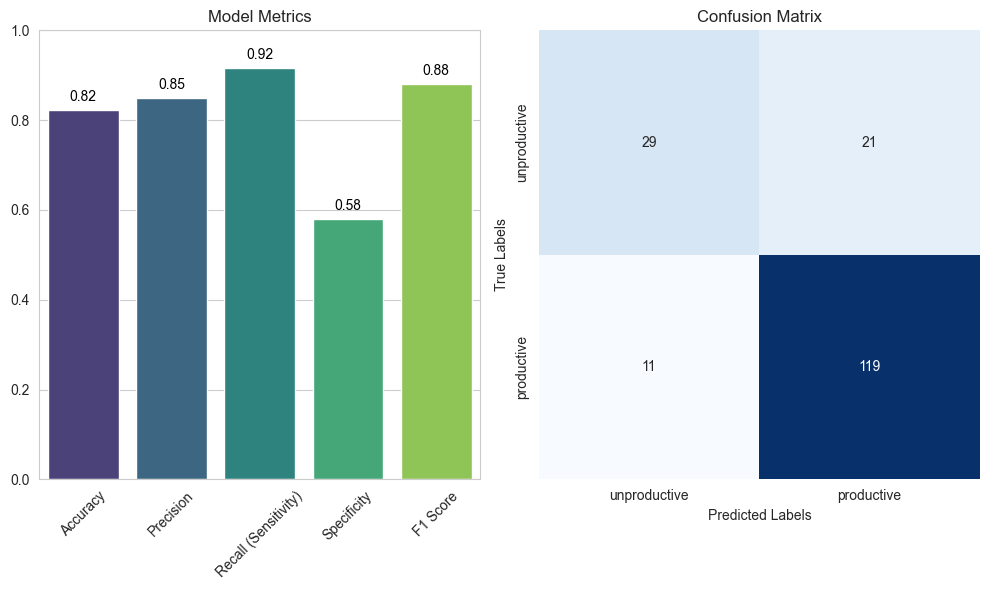

In [56]:
display_model_stats(random_forest_pipeline, X_train, Y_train, X_val, Y_val)